# Data Engineering - Initial Dataset Cleaning

This notebook contains various functions I created to create a smaller, relevant

In [7]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import random
import datetime
import re
from collections import Counter
# from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#stuff from nltk
import nltk
from nltk.tokenize import word_tokenize #<- For finding tokens (small divisions) from a large sample of text
from nltk.corpus import stopwords #<- For calling the know stopwords in english (e.g, articles, connectors)
from nltk.corpus import wordnet #<- For calling a lexical database in eglish with meanings, synonyms, antonyms, and more 
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentAnalyzer

########## progress bar
from tqdm.notebook import tqdm, trange
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import time

sid_analyzer = SentimentIntensityAnalyzer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

##### emotions
import text2emotion as te

pd.set_option('display.max_columns', 100)

### Reading in data

In [8]:
full_list = ["2013","2014","2015","2016","2017-q1","2017-q2","2017-q3",
            "2017-10","2017-11","2017-12","2018-01","2018-02","2018-03",
            "2018-04","2018-05","2018-06","2018-07","2018-08","2018-09",
            "2018-10","2018-11","2018-12","2019-01","2019-02","2019-03",
            "2019-04","2019-05","2019-06","2019-07","2019-08","2019-09",
            "2019-10","2019-11","2019-12","2020-01","2020-02","2020-03",
            "2020-04","2020-05","2020-06","2020-07","2020-08","2020-09",
            "2020-10","2020-11","2020-12","2020-12",
            "2021-01-1","2021-01-2","2021-01-3","2021-01-4",
            "2021-02-1","2021-02-2"]#"2021-02-3","2021-02-4",
#             "2021-03-1","2021-03-2","2021-03-3","2021-03-4",
#             "2021-04-1","2021-04-2",
#              "2021-04-3","2021-04-4",
#             "2021-05-1","2021-05-2","2021-05-3","2021-05-4",]#"april_synthetic","total_synthetic"]

# full_list = ["2013","april_synthetic","2021-05-4"]

# full_list = ['full_data']

data = [t+'.csv' for t in full_list]
dt_cols = {"author": str, "body": str, "created_utc": str, "score": float}
df = pd.concat([pd.read_csv(dataset, usecols=dt_cols, dtype=dt_cols) for dataset in data], ignore_index=True)

# df = pd.concat([pd.read_csv(dataset, low_memory=False, lineterminator='\n',usecols=dt_cols, dtype=dt_cols)] for dataset in data, ignore_index=True) # removed usecols=dt_cols and dtype=dt_cols
# df_na.sort_values(by = 'created_utc')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030560 entries, 0 to 7030559
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   author       object 
 1   body         object 
 2   created_utc  object 
 3   score        float64
dtypes: float64(1), object(3)
memory usage: 214.6+ MB


In [10]:
df

df.to_csv('df.csv', header=True, index=False, columns=list(df.axes[1]))
df

,author,body,created_utc,score
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0
1,mytwobitcents,fixed thanks,1368321753,2.0
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0
...,...,...,...,...
7030555,ChocolateMorsels,"This is insanity. Thank you Elon, very cool!",1612828897,3.0
7030556,Wolfe1,New thread who dis?,1612828897,5.0
7030557,Jooylo,"$1,000,000 would make the market cap of BTC at...",1612828896,2.0
7030558,[deleted],[removed],1612828895,1.0


In [3]:
def clean_removed_deleted(df):
    
    """Input = uncleaned reddit data dataframe with a column called 'body'
    
    Output = body column with removed '[deleted]' '[removed]' entries which do not give us
    anything of value for sentiment analysis
    
    '[deleted]' = deleted post by poster
    '[removed]' = deleted by moderators, either auto or manually
    """
    
    # NA's
    df = df.dropna(how='any')
    
    # Removing '[removed]' entries which create noise, account for about 8% of data
    print('dropping [removed] posts')
    removed = df[df.loc[:, 'body'].progress_apply(lambda x: str(x)=="[removed]")]
    index_r = removed.index
    cleaned_r = pd.DataFrame.drop(df, index = index_r)
    
    # Removing '[deleted]' entries to remove noise
    print(' dropping [deleted] posts')
    deleted = cleaned_r[cleaned_r.loc[:,'body'].progress_apply(lambda x: str(x)=="[deleted]")]
    index_d = deleted.index
    cleaned_d = pd.DataFrame.drop(cleaned_r, index = index_d)
    cleaned = cleaned_d

    return cleaned

cleaned_comments  = clean_removed_deleted(df.copy(deep=True))
cleaned_comments

dropping [removed] posts


  0%|          | 0/11164257 [00:00<?, ?it/s]

 dropping [deleted] posts


  0%|          | 0/10515244 [00:00<?, ?it/s]

,author,body,created_utc,score
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0
1,mytwobitcents,fixed thanks,1368321753,2.0
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0
...,...,...,...,...
11182417,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0
11182418,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0
11182419,ccModBot,Hello!\n\nDirect links to image or video posts...,1621788187,1.0
11182420,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0


In [ ]:
a = pd.Series.value_counts(cleaned_comments['author'])
sum(a)

In [4]:
bot_list = ['AutoModerator', '___alexa___', 'SwapzoneIO', 'ccModBot', 'coinfeeds-bot', 'CryptoMods','[deleted]', '[removed]']

# users = df["author"].value_counts()
# users.head(50)

def remove_bots(df, bot_list, column_name):
    
    """This function is designed to compare authors of comments in dataframe with a predefined list of bot accounts
    
    inputs = dataframe, list of bots, column name (must be a string) in dataframe to compute comparison
    
    output = dataframe with comments by bot accounts removed"""
    is_in = df[~df[column_name].isin(bot_list)]     
    
    return is_in

removed_bots = remove_bots(df=cleaned_comments.copy(deep=True), bot_list = bot_list, column_name = 'author')
removed_bots
# removed_bots['author'].value_count()

,author,body,created_utc,score
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0
1,mytwobitcents,fixed thanks,1368321753,2.0
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0
...,...,...,...,...
11182416,zombiibenny,Now this is an accurate statement.,1621788188,2.0
11182417,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0
11182418,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0
11182420,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0


In [5]:
def clean_hyperlinks(df, column_name):
    
    """This function removed all hyperlinks that behin with 'http' and 
    replace with a whitespace and counts number of hyperlinks removed
    
    Input = Dataframe, selected column to remove hyperlinks
    
    Output = Dataframe with removed hyperlinks in text column
    """
#     count = 0
    
#     for comment in df['body']:
#         if (re.subn(r'http\S+', " ", comment)[1]) > 0:
#             count+=1
                 
#     print("removed hyperlinks in {} rows/comments".format(count))
    
    df[column_name] = df[column_name].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    
    return df

df1 = removed_bots.copy(deep=True)

df2 = clean_hyperlinks(df1, column_name = 'body')
df2

,author,body,created_utc,score
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0
1,mytwobitcents,fixed thanks,1368321753,2.0
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0
...,...,...,...,...
11182416,zombiibenny,Now this is an accurate statement.,1621788188,2.0
11182417,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0
11182418,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0
11182420,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0


In [7]:
def get_datetime(df):
    
    """Reddit does not provide a datetime format, comments based on UTC format
    Input = This function takes in Pandas dataframe and expects the presence of a 'created_utc' column
    to convert to Datetime
    
    Output = New column in dataframe called 'datetime' with date present"""

    df['created_utc'] = df['created_utc'].astype(int)
    x = df['created_utc']
    
    datetime = []
    print('creating datetime column')
    for num in tqdm_notebook(x):
        y = pd.Timestamp(num, unit='s', hour=None)
        datetime.append(y)  
    df['date'] = datetime
    df['date'] = pd.to_datetime(df['date']).dt.date
    df
    
    return df

# df1 = removed_bots.copy(deep=True)

datetime = get_datetime(df)
datetime#.info()

# datetime['date'] = pd.to_datetime(datetime['date']).dt.date

creating datetime column


  0%|          | 0/10094414 [00:00<?, ?it/s]

,author,body,created_utc,score,date,Compound Sentiment Score
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0,2013-05-12,0.9014
1,mytwobitcents,fixed thanks,1368321753,2.0,2013-05-12,0.4404
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12,-0.4767
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0,2013-05-12,0.0000
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0,2013-05-11,0.4019
...,...,...,...,...,...,...
10094409,zombiibenny,Now this is an accurate statement.,1621788188,2.0,2021-05-23,0.0000
10094410,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23,0.8091
10094411,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0,2021-05-23,-0.3869
10094412,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0,2021-05-23,0.0000


In [155]:
datetime

,author,body,created_utc,score,date
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0,2013-05-12
1,mytwobitcents,fixed thanks,1368321753,2.0,2013-05-12
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0,2013-05-12
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0,2013-05-11
...,...,...,...,...,...
11182416,zombiibenny,Now this is an accurate statement.,1621788188,2.0,2021-05-23
11182417,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23
11182418,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0,2021-05-23
11182420,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0,2021-05-23


In [7]:
datetime.info()

df = datetime.copy(deep=True)
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9984839 entries, 0 to 11182421
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   author       object        
 1   body         object        
 2   created_utc  int32         
 3   score        float64       
 4   date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 419.0+ MB


,author,body,created_utc,score,date
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0,2013-05-12 04:26:58
1,mytwobitcents,fixed thanks,1368321753,2.0,2013-05-12 01:22:33
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12 00:31:57
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0,2013-05-12 00:29:24
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0,2013-05-11 18:49:45
...,...,...,...,...,...
11182416,zombiibenny,Now this is an accurate statement.,1621788188,2.0,2021-05-23 16:43:08
11182417,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23 16:43:08
11182418,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0,2021-05-23 16:43:08
11182420,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0,2021-05-23 16:43:06


In [8]:
# df.to_csv('new_cleaned_sentiment.csv', header=True, index=False, columns=list(df.axes[1]))
# def sort_dataframe(df):
#     return    pd.DataFrame.sort_values(df, 'date')
# df = sort_dataframe(b)
# df

In [28]:
# users = df["author"].unique()
# len(users)
# sum(users.head(500))

398481

In [30]:
# stats = +

# small_df = df.tail(1000000)
# df_s = small_df.copy(deep=True)
# df_s

,author,body,created_utc,score
date,,,,
2021-04-07,36944,36944,36944,36944
2021-04-08,30192,30192,30192,30192
2021-04-09,23421,23421,23421,23421
2021-04-10,23005,23005,23005,23005
2021-04-11,30093,30093,30093,30093
2021-04-12,24979,24979,24979,24979
2021-04-13,31498,31498,31498,31498
2021-04-14,35486,35486,35486,35486
2021-04-15,48784,48784,48784,48784


In [9]:
def get_sentiment(text:str, analyser, desired_type:str='pos'):
    # Get sentiment from text
    sentiment_score = analyser.polarity_scores(text)
    return sentiment_score[desired_type]

def get_sentiment_scores(df,data_column):
    print('Getting compound sentiment')
    df['Compound Sentiment Score'] = df[data_column].astype(str).progress_apply(lambda x: get_sentiment(x,sid_analyzer,'compound'))
    
#     print('Getting compound sentiment')
#     df['Positive Sentiment Score'] = df[data_column].astype(str).progress_apply(lambda x: get_sentiment(x,sid_analyzer,'pos'))
    
#     print('Getting compound sentiment')
#     df['Negative Sentiment Score'] = df[data_column].astype(str).progress_apply(lambda x: get_sentiment(x,sid_analyzer,'neg'))
    
#     print('Getting compound sentiment')
#     df['Neutral Sentiment Score'] = df[data_column].astype(str).progress_apply(lambda x: get_sentiment(x,sid_analyzer,'neu'))
    return df

# df_small

df = get_sentiment_scores(df, 'body')
df

Getting compound sentiment


  0%|          | 0/9984839 [00:00<?, ?it/s]

,author,body,created_utc,score,date,Compound Sentiment Score
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0,2013-05-12 04:26:58,0.9014
1,mytwobitcents,fixed thanks,1368321753,2.0,2013-05-12 01:22:33,0.4404
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12 00:31:57,-0.4767
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0,2013-05-12 00:29:24,0.0000
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0,2013-05-11 18:49:45,0.4019
...,...,...,...,...,...,...
11182416,zombiibenny,Now this is an accurate statement.,1621788188,2.0,2021-05-23 16:43:08,0.0000
11182417,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23 16:43:08,0.8091
11182418,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0,2021-05-23 16:43:08,-0.3869
11182420,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0,2021-05-23 16:43:06,0.0000


In [193]:
# df.to_csv('cleaned_df_sentiment.csv', header=True, index=False, columns=list(df.axes[1]))

In [2]:
df = pd.read_csv('cleaned_df_sentiment_synthetic.csv')
df

,author,body,created_utc,score,date,Compound Sentiment Score
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0,2013-05-12 04:26:58,0.9014
1,mytwobitcents,fixed thanks,1368321753,2.0,2013-05-12 01:22:33,0.4404
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12 00:31:57,-0.4767
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0,2013-05-12 00:29:24,0.0000
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0,2013-05-11 18:49:45,0.4019
...,...,...,...,...,...,...
10094409,zombiibenny,Now this is an accurate statement.,1621788188,2.0,2021-05-23 16:43:08,0.0000
10094410,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23 16:43:08,0.8091
10094411,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0,2021-05-23 16:43:08,-0.3869
10094412,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0,2021-05-23 16:43:06,0.0000


In [3]:
df = get_datetime(df)

# def lemmatize_text(text):
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


NameError: name 'get_datetime' is not defined

In [9]:
date = pd.DatetimeIndex(datetime['date'])
date
df['date'] = date
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10094414 entries, 0 to 10094413
Data columns (total 6 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   author                    object        
 1   body                      object        
 2   created_utc               int32         
 3   score                     float64       
 4   date                      datetime64[ns]
 5   Compound Sentiment Score  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), object(2)
memory usage: 423.6+ MB


,author,body,created_utc,score,date,Compound Sentiment Score
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0,2013-05-12,0.9014
1,mytwobitcents,fixed thanks,1368321753,2.0,2013-05-12,0.4404
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12,-0.4767
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0,2013-05-12,0.0000
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0,2013-05-11,0.4019
...,...,...,...,...,...,...
10094409,zombiibenny,Now this is an accurate statement.,1621788188,2.0,2021-05-23,0.0000
10094410,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23,0.8091
10094411,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0,2021-05-23,-0.3869
10094412,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0,2021-05-23,0.0000


In [10]:

sentiment_pos = df_clean_pos.groupby([pd.Grouper('Compound Sentiment Score')])['date']

# sentiment_neg = df_clean_neg.groupby([pd.Grouper(key='date',freq='D')])['Compound Sentiment Score']

# des_pos = sentiment_pos.describe()
# des_neg = sentiment_neg.describe()
# des_pos
sentiment = df.groupby([pd.Grouper(key='Compound Sentiment Score')])['date'].count()
sentiment.describe()

# sentiment_pos

# pd.pivot_table(df_clean_neg, columns='date')

NameError: name 'df_clean_pos' is not defined

In [105]:
des_neg

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2013-03-12,3.0,-0.431033,0.197012,-0.6571,-0.498550,-0.34000,-0.318000,-0.2960
2013-03-13,2.0,-0.706750,0.088742,-0.7695,-0.738125,-0.70675,-0.675375,-0.6440
2013-03-14,2.0,-0.469850,0.019728,-0.4838,-0.476825,-0.46985,-0.462875,-0.4559
2013-03-15,1.0,-0.361200,NaN,-0.3612,-0.361200,-0.36120,-0.361200,-0.3612
2013-03-16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-05-27,6837.0,-0.522975,0.183750,-0.9972,-0.648600,-0.49390,-0.361200,-0.2509
2021-05-28,7212.0,-0.516150,0.179998,-0.9941,-0.644100,-0.49390,-0.361200,-0.2509
2021-05-29,6762.0,-0.522546,0.179968,-0.9925,-0.648600,-0.49525,-0.373600,-0.2502


(array([ 2805.,  3068.,  4985.,  5861.,  5432., 10628.,  5080.,  5560.,
         3148.,  3742.,  4023.,  5793.,  4693.,  4313.,  4395.,  3804.,
         4233.,  3969.,  3848.,  3442.,  3163.,  2548.,  1467.]),
 array([0.2501    , 0.28269565, 0.3152913 , 0.34788696, 0.38048261,
        0.41307826, 0.44567391, 0.47826957, 0.51086522, 0.54346087,
        0.57605652, 0.60865217, 0.64124783, 0.67384348, 0.70643913,
        0.73903478, 0.77163043, 0.80422609, 0.83682174, 0.86941739,
        0.90201304, 0.9346087 , 0.96720435, 0.9998    ]),
 <BarContainer object of 23 artists>)

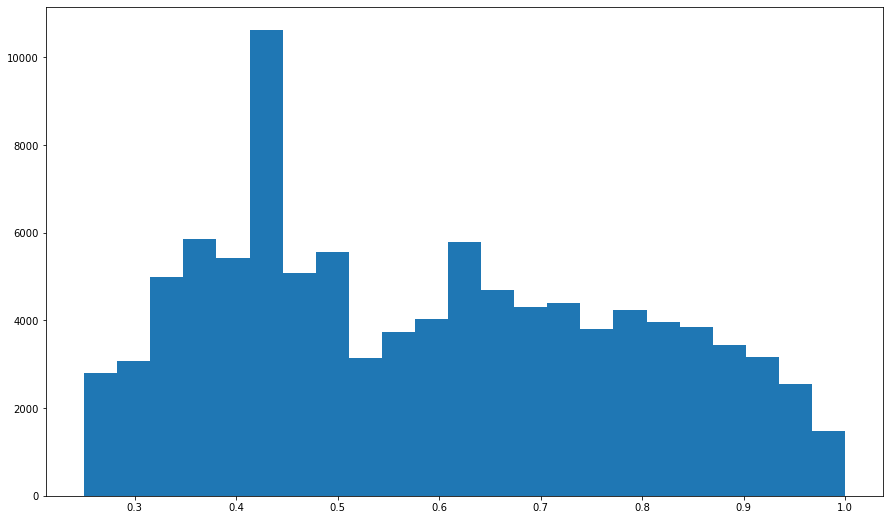

In [85]:
plt.figure(figsize=(15,9))


sentiment_pos = df_clean_pos['Compound Sentiment Score']
len(sentiment_pos)
plt.hist(x = sentiment_pos, bins=23, label = 'surprise')
# plt.plot(range(0,100000),sentiment_pos)

# plt.grid()
# plt.legend()  
# plt.show()

(array([  792.,  1720.,  2391.,  2976.,  3293.,  4025.,  3798.,  4261.,
         5524.,  4634.,  6609.,  8926.,  5858.,  6862.,  6456.,  8226.,
         7350., 11090.,  5209.]),
 array([-1.        , -0.96053158, -0.92106316, -0.88159474, -0.84212632,
        -0.80265789, -0.76318947, -0.72372105, -0.68425263, -0.64478421,
        -0.60531579, -0.56584737, -0.52637895, -0.48691053, -0.44744211,
        -0.40797368, -0.36850526, -0.32903684, -0.28956842, -0.2501    ]),
 <BarContainer object of 19 artists>)

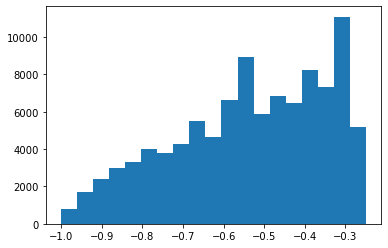

In [118]:
sentiment_neg = df_clean_neg['Compound Sentiment Score']


plt.hist(x = sentiment_neg, bins=19, label = 'surprise')


count    1.771045e+06
mean    -5.356724e-01
std      1.872740e-01
min     -1.000000e+00
25%     -6.705000e-01
50%     -5.152000e-01
75%     -3.818000e-01
max     -2.501000e-01
Name: Compound Sentiment Score, dtype: float64

In [207]:
# positive_sentiment = df['Compound Sentiment Score'] >= 0.05

# positive_df = pd.DataFrame()

# for row in df:
    
# positive = (df['Compound Sentiment Score']>=0.05)

# df.index(df['Compound Sentiment Score']>=0.05).tolist()
    
# for idx in range(0, len(df['Compound Sentiment Score'])):
    
#     value = df['Compound Sentiment Score'][idx]
#     print(value)
#     positive = df.index[df[value>=0.05 == True]#.tolist()
                        
df['Positive Compound'] = df['Compound Sentiment Score'] >= 0.5
df['Negative Compound'] = df['Compound Sentiment Score'] <= -0.05
#     print(positive)
df
# idx=5

df_positive = df.copy(deep=True)
df_negative = df.copy(deep=True)
    


# df['Compound Sentiment Score'][idx]

df
# for i in positive_sentiment:
#     print(i)

,author,body,created_utc,score,date,Compound Sentiment Score,Positive Compound,Negative Compound
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0,2013-05-12,0.9014,True,False
1,mytwobitcents,fixed thanks,1368321753,2.0,2013-05-12,0.4404,False,False
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12,-0.4767,False,True
3,sex_with_a_goat,"You mean ""criptomoneda"".",1368318564,1.0,2013-05-12,0.0000,False,False
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0,2013-05-11,0.4019,False,False
...,...,...,...,...,...,...,...,...
10094409,zombiibenny,Now this is an accurate statement.,1621788188,2.0,2021-05-23,0.0000,False,False
10094410,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23,0.8091,True,False
10094411,snamm,"Looking at the 5 year chart, we have only had ...",1621788188,11.0,2021-05-23,-0.3869,False,True
10094412,Alauren2,Tails! That’s it. This sounds similar to his B...,1621788186,1.0,2021-05-23,0.0000,False,False


### positive sentiment

In [210]:
df_positive
# df_positive['Positive Compound'] == True
# df_positive_drop = 
# df_positive['Compound Sentiment Score' == False]

df_positive_drop = df_positive[df_positive['Compound Sentiment Score'] <= 0.25].index
df_positive_drop
df_clean_pos = df_positive.drop(index = df_positive_drop)
# df_positive
df_clean_pos

# df_clean_pos = pd.DataFrame.sample(df_clean_pos, n=1786770)
# df_clean_pos.tail(45)
# jan = df[(df['date'] > '2013-04-01') & (df['date'] <= '2021-4-01')]


,author,body,created_utc,score,date,Compound Sentiment Score,Positive Compound,Negative Compound
0,TechnoMagik,I'm not sure how you eliminate spread.. If I a...,1368332818,1.0,2013-05-12,0.9014,True,False
1,mytwobitcents,fixed thanks,1368321753,2.0,2013-05-12,0.4404,False,False
4,davidpbrown,"Yes, Russian Trolls are the most obvious answer.",1368298185,2.0,2013-05-11,0.4019,False,False
8,Xandie6,Btc-e.com trades high volumes in many popular ...,1368250990,1.0,2013-05-11,0.5994,True,False
10,HuRyde,Whats a safe alternative to trade NMC to BTC?,1368241994,2.0,2013-05-11,0.4404,False,False
...,...,...,...,...,...,...,...,...
10094402,sethinak76,Yep. I didn't sell then and wont now,1621788193,2.0,2021-05-23,0.2960,False,False
10094404,StupidQuestionsAgain,But the one at the bakery is more useful,1621788190,2.0,2021-05-23,0.6474,True,False
10094406,youtink,"yeah same here I don't sell but I do stake it,...",1621788190,1.0,2021-05-23,0.6640,True,False
10094410,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23,0.8091,True,False


In [211]:
df_negative_drop = df_negative[df_negative['Compound Sentiment Score'] >= -0.25].index
df_negative
df_clean_neg = df_negative.drop(index = df_negative_drop)
# df_positive
# df_clean_neg = pd.DataFrame.sample(df_clean_neg, n=200000)
df_clean_neg

,author,body,created_utc,score,date,Compound Sentiment Score,Positive Compound,Negative Compound
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12,-0.4767,False,True
6,davidpbrown,Websites get hacked.. news at 11.\n\nDon't kee...,1368255591,3.0,2013-05-11,-0.4019,False,True
9,sgodsdogs,it seems there's been a lot of talking heads i...,1368249064,5.0,2013-05-11,-0.5574,False,True
26,hyh123,I see. But copycats of the world don't seem to...,1368117303,1.0,2013-05-09,-0.8221,False,True
30,AltClubGirls,Sorry that setting was changed by mistake. It ...,1368080817,1.0,2013-05-09,-0.4019,False,True
...,...,...,...,...,...,...,...,...
10094398,Gbear831,That’s just the market big money moves on \n\n...,1621788195,5.0,2021-05-23,-0.5813,False,True
10094399,Benderineurope,"Yikes, do you think ether can get that low?",1621788195,2.0,2021-05-23,-0.2732,False,True
10094403,TRexShrimpboi,Brutal,1621788191,1.0,2021-05-23,-0.6249,False,True
10094407,seethingslug,Because it’s a worthless commodity people are ...,1621788189,3.0,2021-05-23,-0.4404,False,True


In [212]:



nonneutral = pd.concat((df_clean_neg, df_clean_pos))
nonneutral



,author,body,created_utc,score,date,Compound Sentiment Score,Positive Compound,Negative Compound
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12,-0.4767,False,True
6,davidpbrown,Websites get hacked.. news at 11.\n\nDon't kee...,1368255591,3.0,2013-05-11,-0.4019,False,True
9,sgodsdogs,it seems there's been a lot of talking heads i...,1368249064,5.0,2013-05-11,-0.5574,False,True
26,hyh123,I see. But copycats of the world don't seem to...,1368117303,1.0,2013-05-09,-0.8221,False,True
30,AltClubGirls,Sorry that setting was changed by mistake. It ...,1368080817,1.0,2013-05-09,-0.4019,False,True
...,...,...,...,...,...,...,...,...
10094402,sethinak76,Yep. I didn't sell then and wont now,1621788193,2.0,2021-05-23,0.2960,False,False
10094404,StupidQuestionsAgain,But the one at the bakery is more useful,1621788190,2.0,2021-05-23,0.6474,True,False
10094406,youtink,"yeah same here I don't sell but I do stake it,...",1621788190,1.0,2021-05-23,0.6640,True,False
10094410,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23,0.8091,True,False


In [215]:
from sklearn import preprocessing

preprocessing.scale()

TypeError: scale() missing 1 required positional argument: 'X'

No handles with labels found to put in legend.


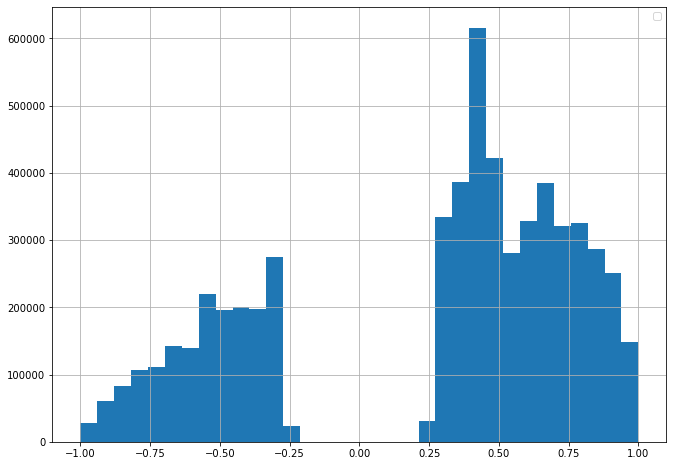

In [213]:
plt.figure(figsize=(11,8))

plt.hist(nonneutral['Compound Sentiment Score'], bins=33)
# plt.plot(range(0,len(fear_bitcoin),1), fear_bitcoin, c='limegreen', label = 'fear')

plt.grid()
plt.legend()  
plt.show()

### negative

In [158]:
df_negative_drop = df_negative[df_negative['Compound Sentiment Score'] >= -0.25].index
df_negative
df_clean_neg = df_negative.drop(index = df_negative_drop)
# df_positive
# df_clean_neg = pd.DataFrame.sample(df_clean_neg, n=200000)
df_clean_neg

,author,body,created_utc,score,date,Compound Sentiment Score,Positive Compound,Negative Compound
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12,-0.4767,False,True
6,davidpbrown,Websites get hacked.. news at 11.\n\nDon't kee...,1368255591,3.0,2013-05-11,-0.4019,False,True
9,sgodsdogs,it seems there's been a lot of talking heads i...,1368249064,5.0,2013-05-11,-0.5574,False,True
26,hyh123,I see. But copycats of the world don't seem to...,1368117303,1.0,2013-05-09,-0.8221,False,True
30,AltClubGirls,Sorry that setting was changed by mistake. It ...,1368080817,1.0,2013-05-09,-0.4019,False,True
...,...,...,...,...,...,...,...,...
10094398,Gbear831,That’s just the market big money moves on \n\n...,1621788195,5.0,2021-05-23,-0.5813,False,True
10094399,Benderineurope,"Yikes, do you think ether can get that low?",1621788195,2.0,2021-05-23,-0.2732,False,True
10094403,TRexShrimpboi,Brutal,1621788191,1.0,2021-05-23,-0.6249,False,True
10094407,seethingslug,Because it’s a worthless commodity people are ...,1621788189,3.0,2021-05-23,-0.4404,False,True


No handles with labels found to put in legend.


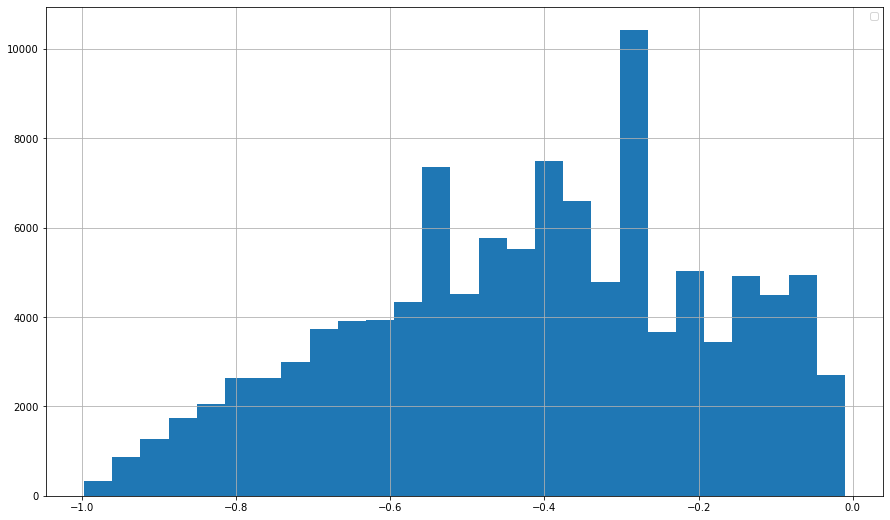

In [144]:
nov19 = df_clean_neg[(df_clean_neg['date'] > '2021-2-01') & (df_clean_neg['date'] <= '2021-3-7')]
nov19
plt.figure(figsize=(15,9))

plt.hist(nov19['Compound Sentiment Score'], bins=27)
# plt.plot(range(0,len(fear_bitcoin),1), fear_bitcoin, c='limegreen', label = 'fear')

plt.grid()
plt.legend()  
plt.show()

No handles with labels found to put in legend.


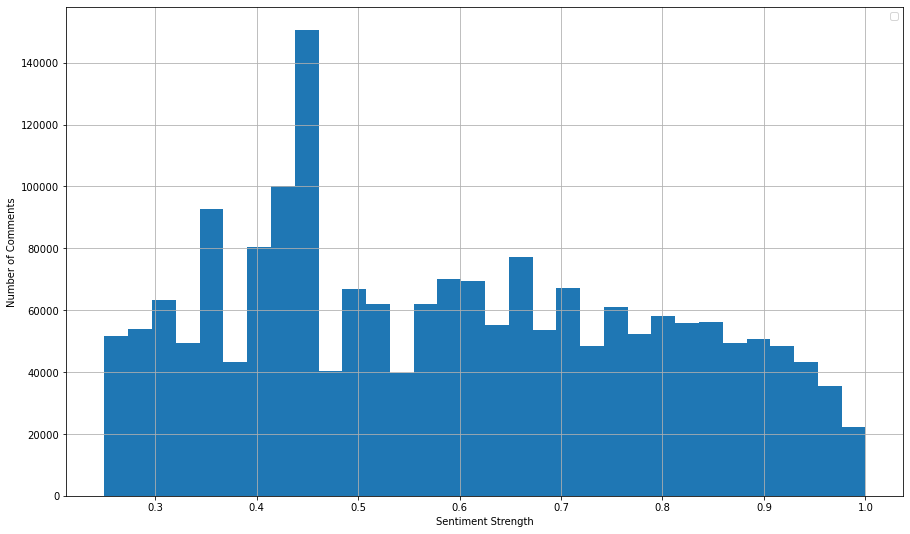

In [223]:
nov19 = df_clean_pos[(df_clean_pos['date'] > '2016-6-01') & (df_clean_pos['date'] <= '2020-5-7')]
nov19
plt.figure(figsize=(15,9))

plt.hist(nov19['Compound Sentiment Score'], bins=32)
# plt.plot(range(0,len(fear_bitcoin),1), fear_bitcoin, c='limegreen', label = 'fear')

plt.xlabel("Sentiment Strength")
plt.ylabel("Number of Comments")


plt.grid()
plt.legend()  
plt.show()

In [216]:
# df3 = df_clean_neg.set_index(['date'])
# df3 = df_clean_neg.set_index(['date'])
# df_clean_neg[df_clean_neg.date.between(start_date, end_date)]
df_clean_neg.describe()
# df_clean_neg

# nonneutral = pd.concat((df_clean_neg, df_clean_pos))
nonneutral

,author,body,created_utc,score,date,Compound Sentiment Score,Positive Compound,Negative Compound
2,sex_with_a_goat,"The Spanish one is wrong, we don't use 'y' wit...",1368318717,2.0,2013-05-12,-0.4767,False,True
6,davidpbrown,Websites get hacked.. news at 11.\n\nDon't kee...,1368255591,3.0,2013-05-11,-0.4019,False,True
9,sgodsdogs,it seems there's been a lot of talking heads i...,1368249064,5.0,2013-05-11,-0.5574,False,True
26,hyh123,I see. But copycats of the world don't seem to...,1368117303,1.0,2013-05-09,-0.8221,False,True
30,AltClubGirls,Sorry that setting was changed by mistake. It ...,1368080817,1.0,2013-05-09,-0.4019,False,True
...,...,...,...,...,...,...,...,...
10094402,sethinak76,Yep. I didn't sell then and wont now,1621788193,2.0,2021-05-23,0.2960,False,False
10094404,StupidQuestionsAgain,But the one at the bakery is more useful,1621788190,2.0,2021-05-23,0.6474,True,False
10094406,youtink,"yeah same here I don't sell but I do stake it,...",1621788190,1.0,2021-05-23,0.6640,True,False
10094410,Ajelandrus,HAHA exactly me hahaha,1621788188,1.0,2021-05-23,0.8091,True,False


No handles with labels found to put in legend.


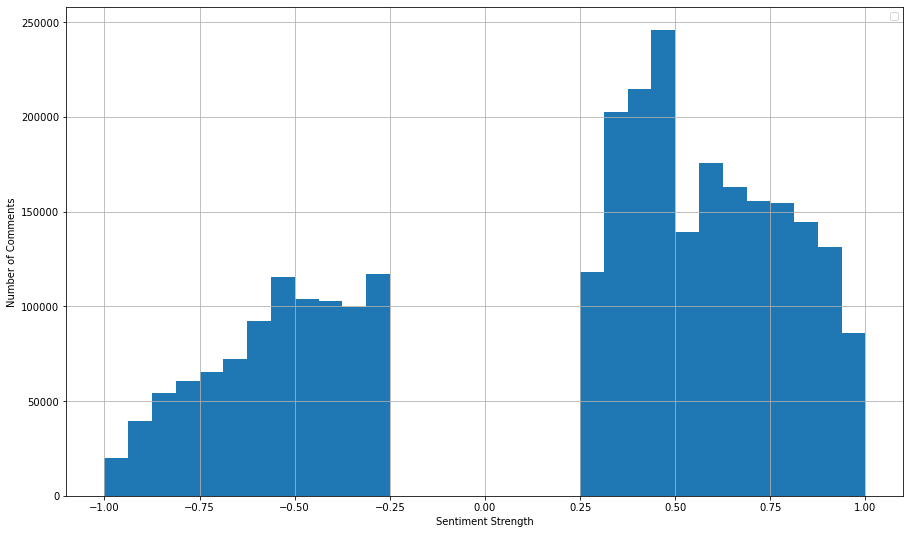

In [217]:
nov19 = nonneutral[(nonneutral['date'] > '2016-6-01') & (nonneutral['date'] <= '2020-5-7')]
nov19
plt.figure(figsize=(15,9))

plt.hist(nov19['Compound Sentiment Score'], bins=32)
# plt.plot(range(0,len(fear_bitcoin),1), fear_bitcoin, c='limegreen', label = 'fear')

plt.xlabel("Sentiment Strength")
plt.ylabel("Number of Comments")


plt.grid()
plt.legend()  
plt.show()

In [229]:
compound_sentiment_sum_bitcoin = nonneutral.groupby([pd.Grouper(key='date',freq='D')])['Compound Sentiment Score'].mean()
compound_sentiment_sum_bitcoin[:1500]


date
2013-03-11    0.591600
2013-03-12    0.448564
2013-03-13    0.438962
2013-03-14    0.189343
2013-03-15    0.539100
                ...   
2017-04-14    0.256340
2017-04-15    0.389373
2017-04-16    0.383423
2017-04-17    0.394747
2017-04-18    0.236687
Freq: D, Name: Compound Sentiment Score, Length: 1500, dtype: float64

### graph positive

In [221]:
max(compound_sentiment_sum_bitcoin), min(compound_sentiment_sum_bitcoin)
compound_values = compound_sentiment_sum_bitcoin.values
#compound min and max value
min_sent_comp = min(compound_values)
max_sent_comp = max(compound_values)


#containers for plotting to append normalised values
norm_comp_list = []

for i in range(0,len(compound_values)):
    z_i = (compound_values[i]-min_sent_comp)/(max_sent_comp-min_sent_comp)
    
    norm_comp_list.append(z_i)
    
norm_comp_list

3004

No handles with labels found to put in legend.


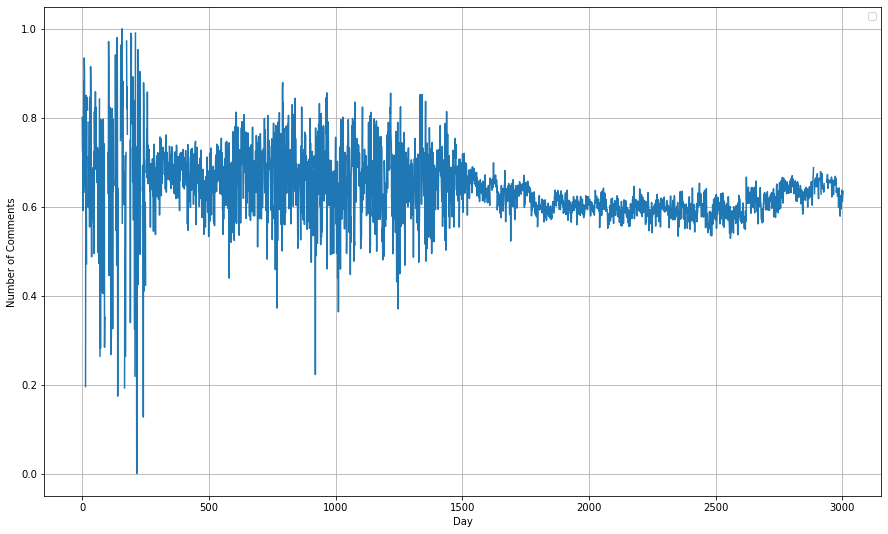

In [227]:
# nov19 = nonneutral[(nonneutral['date'] > '2016-6-01') & (nonneutral['date'] <= '2020-5-7')]
# nov19
plt.figure(figsize=(15,9))

plt.plot(range(0,len(norm_comp_list)), norm_comp_list)
# plt.plot(range(0,len(fear_bitcoin),1), fear_bitcoin, c='limegreen', label = 'fear')

plt.xlabel("Day")
plt.ylabel("Number of Comments")


plt.grid()
plt.legend()  
plt.show()

In [270]:
import re
df_small_bitcoin = nonneutral.copy()
df_1 = df_small_bitcoin[df_small_bitcoin['body'].str.contains(r'bitcoin')]
df_2 = df_small_bitcoin[df_small_bitcoin['body'].str.contains(r'btc')]
df_3 = df_small_bitcoin[df_small_bitcoin['body'].str.contains(r'whale')]
df_4 = df_small_bitcoin[df_small_bitcoin['body'].str.contains(r'whales')]
df_5 = df_small_bitcoin[df_small_bitcoin['body'].str.contains(r'hodl')]
df_6 = df_small_bitcoin[df_small_bitcoin['body'].str.contains(r'halving')]


df_small_bitcoin = pd.concat((df_1, df_2, df_3, df_4, df_5, df_6))
# df_small_bitcoin[4000:]

,author,body,created_utc,score,date,Compound Sentiment Score,Positive Compound,Negative Compound
5891702,DMcIsaac,This is why hardrive wallets are a must have. ...,1610339048,1.0,2021-01-11,-0.4404,False,True
5891714,lenewnicemaymayman2,`Even with a governmental meltdown I still giv...,1610338985,0.0,2021-01-11,-0.8217,False,True
5891889,ryryrocco,"This is for the gneubs out there, not sure if ...",1610347537,5.0,2021-01-11,-0.3895,False,True
5892045,cryptomhanks,There was a time when bitcoin traded on only 1...,1610355244,5.0,2021-01-11,-0.2732,False,True
5892300,TehBananaBread,With this mindset bitcoin would shoot to 500k ...,1610364299,3.0,2021-01-11,-0.6159,False,True
...,...,...,...,...,...,...,...,...
10079396,ukdudeman,The trick is not to do what everybody else is ...,1621993023,1.0,2021-05-26,0.3559,False,False
10083803,Clubtropper,Not to mention Bitcoin literally sets the enti...,1622027984,4.0,2021-05-26,0.4215,False,False
10083954,idevcg,That's literally how it is... just because bul...,1621967088,1.0,2021-05-25,0.3612,False,False
10093157,Lahnmir,I don’t think halving means what you think it ...,1621788069,399.0,2021-05-23,0.6249,True,False


In [ ]:
df_small_bitcoin[40000:]

In [233]:
# nov19 = df_small_bitcoin[(df_small_bitcoin['date'] > '2016-6-01') & (df_small_bitcoin['date'] <= '2020-5-7')]
# nov19
# plt.figure(figsize=(15,9))

# plt.hist(nov19['Compound Sentiment Score'], bins=62)
# # plt.plot(range(0,len(fear_bitcoin),1), fear_bitcoin, c='limegreen', label = 'fear')

# # plt.xlabel("Sentiment Strength")
# plt.ylabel("Number of Comments")


# plt.grid()
# plt.legend()  
# plt.show()

In [262]:
compound_sentiment_bitcoin = df_small_bitcoin.groupby([pd.Grouper(key='date',freq='D')])['Compound Sentiment Score'].mean()
lin_reg_sent = compound_sentiment_bitcoin[1205:]
lin_reg_sent

date
2016-06-29    0.350600
2016-06-30    0.298300
2016-07-01    0.427550
2016-07-02    0.784300
2016-07-03    0.764550
                ...   
2021-05-27    0.218341
2021-05-28    0.245084
2021-05-29    0.227449
2021-05-30    0.257909
2021-05-31    0.272840
Freq: D, Name: Compound Sentiment Score, Length: 1798, dtype: float64

In [267]:
bitcoin_sentiment = pd.Series.to_frame(lin_reg_sent)
# date = bitcoin_sentiment.index
bitcoin_sentiment['date'] = date
bitcoin_sentiment

,Compound Sentiment Score,date
date,,
2016-06-29,0.350600,2016-06-29
2016-06-30,0.298300,2016-06-30
2016-07-01,0.427550,2016-07-01
2016-07-02,0.784300,2016-07-02
2016-07-03,0.764550,2016-07-03
...,...,...
2021-05-27,0.218341,2021-05-27
2021-05-28,0.245084,2021-05-28
2021-05-29,0.227449,2021-05-29


In [268]:
bitcoin_sentiment.to_csv('bitcoin_sentiment.csv', header=True, index=False, columns=list(bitcoin_sentiment.axes[1]))

In [237]:
max(compound_sentiment_bitcoin), min(compound_sentiment_bitcoin)
compound_values = compound_sentiment_sum_bitcoin.values
#compound min and max value
min_sent_comp = min(compound_values)
max_sent_comp = max(compound_values)


#containers for plotting to append normalised values
norm_comp_list_bitcoin = []

for i in range(0,len(compound_values)):
    z_i = (compound_values[i]-min_sent_comp)/(max_sent_comp-min_sent_comp)
    
    norm_comp_list_bitcoin.append(z_i)
    
norm_comp_list_bitcoin

[0.8005302557704305,
 0.7261715722414412,
 0.7211800295081643,
 0.591413421263702,
 0.7732376793512165,
 0.7632266880551346,
 0.8835516739446871,
 0.7590975254730713,
 0.9343418590143481,
 0.9022665834892909,
 0.6430390933666043,
 0.6326332570874056,
 nan,
 0.1956747764608027,
 0.7572606917585083,
 0.8502807236431692,
 0.7219276356830943,
 0.4717586816385943,
 nan,
 nan,
 0.8452640881680183,
 0.8173216885007278,
 nan,
 0.7901590767311292,
 0.597986847577459,
 0.712856103139946,
 0.6660601649684619,
 0.656529423996673,
 0.6348661735436534,
 0.5544395924308588,
 0.8460178831357871,
 0.734930216628136,
 0.6597761772434262,
 0.9150758993553754,
 0.86642233312539,
 0.6938379427462397,
 0.5520291813959937,
 0.4873154501975463,
 0.5968385170662152,
 0.5715845290081097,
 0.6872010813058849,
 0.6009738684411173,
 0.652203457802335,
 0.6231648991474319,
 0.6636366336927785,
 0.5620711166562695,
 0.7241630276564774,
 0.4947234352256187,
 0.8137242669993762,
 0.7417119686302469,
 0.822208359326263

No handles with labels found to put in legend.


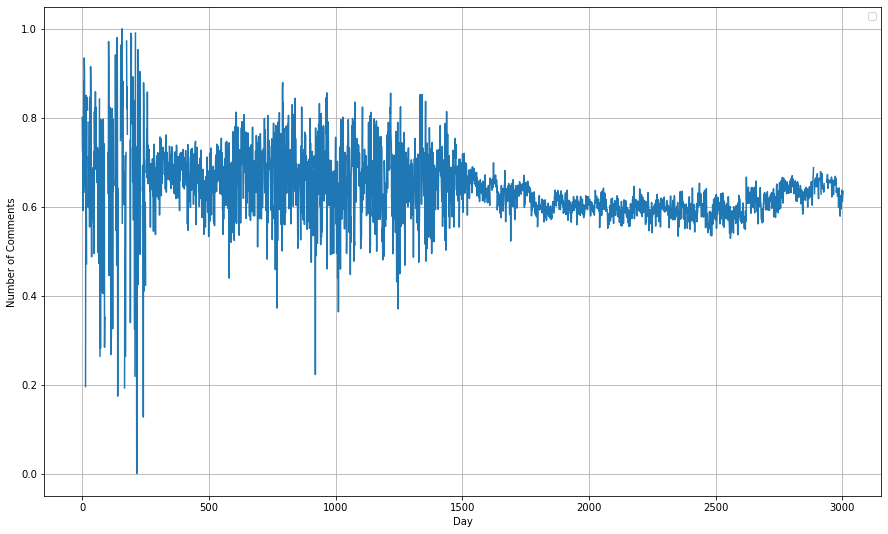

In [238]:
plt.figure(figsize=(15,9))

plt.plot(range(0,len(norm_comp_list_bitcoin)), norm_comp_list_bitcoin)
# plt.plot(range(0,len(fear_bitcoin),1), fear_bitcoin, c='limegreen', label = 'fear')

plt.xlabel("Day")
plt.ylabel("Number of Comments")


plt.grid()
plt.legend()  
plt.show()

### graph negative

In [195]:
from itertools import chain
from collections import Counter

comments = []

for comment in nonneutral['body']:
    comment = word_tokenize(comment)

    comments.append(comment)
    
 

In [196]:
comments

[['The',
  'Spanish',
  'one',
  'is',
  'wrong',
  ',',
  'we',
  'do',
  "n't",
  'use',
  "'",
  'y',
  "'",
  'with',
  'vowel',
  'sound',
  'in',
  'the',
  'middle',
  'of',
  'words',
  ',',
  'only',
  'at',
  'the',
  'end',
  '.',
  'So',
  'it',
  "'s",
  '``',
  'criptomoneda',
  "''",
  '.'],
 ['Websites',
  'get',
  'hacked',
  '..',
  'news',
  'at',
  '11',
  '.',
  'Do',
  "n't",
  'keep',
  'your',
  'money',
  'in',
  'the',
  'exchanges',
  '.'],
 ['it',
  'seems',
  'there',
  "'s",
  'been',
  'a',
  'lot',
  'of',
  'talking',
  'heads',
  'in',
  'the',
  'media',
  'that',
  'say',
  'this',
  '.',
  'That',
  "'s",
  'when',
  'you',
  'know',
  'they',
  "'re",
  'full',
  'of',
  'shit',
  '.'],
 ['I',
  'see',
  '.',
  'But',
  'copycats',
  'of',
  'the',
  'world',
  'do',
  "n't",
  'seem',
  'to',
  'care',
  'about',
  'licenses',
  '.',
  'If',
  'big',
  'money',
  'is',
  'involved',
  ',',
  'people',
  'may',
  'even',
  'do',
  'worse',
  'thing

In [198]:

values = Counter(chain.from_iterable(comments))

most_common = values.most_common()

In [201]:
most_common

[('.', 6219111),
 ('the', 3757902),
 (',', 3579779),
 ('to', 3006866),
 ('a', 2520171),
 ('I', 2395379),
 ('and', 2220893),
 ('is', 1977132),
 ('it', 1889116),
 ('of', 1823469),
 ('you', 1605168),
 ('that', 1420479),
 ('in', 1378457),
 ('for', 1102888),
 ('?', 927472),
 ('on', 860439),
 ('are', 841599),
 ("'s", 825987),
 ('be', 814957),
 ("n't", 770345),
 ('this', 759934),
 ('’', 752251),
 ('have', 710701),
 ('not', 690483),
 ('with', 651755),
 ('but', 636946),
 ('they', 602214),
 ('do', 569019),
 ('!', 563062),
 ('will', 558557),
 ('(', 550655),
 ('*', 526138),
 ('as', 521727),
 (')', 508248),
 ('just', 503102),
 ('like', 482033),
 ('at', 473283),
 ('can', 466716),
 ('your', 461264),
 ('or', 456678),
 ('was', 450879),
 ('if', 443770),
 ('my', 424735),
 ('all', 420622),
 ('people', 416408),
 ('so', 404690),
 ('about', 398647),
 ('It', 388768),
 ('more', 379457),
 ('crypto', 367994),
 ('would', 356211),
 ('what', 343064),
 ('from', 334714),
 ('up', 334581),
 (';', 324357),
 ('has', 3208

In [194]:
nonneutral['body']

2          The Spanish one is wrong, we don't use 'y' wit...
6          Websites get hacked.. news at 11.\n\nDon't kee...
9          it seems there's been a lot of talking heads i...
26         I see. But copycats of the world don't seem to...
30         Sorry that setting was changed by mistake. It ...
                                 ...                        
7396666    "Fundamentals" have not mattered much in crypt...
8353963    Yes!!! I wanted to sell some of my eth a coupl...
9942041    I got in juuuust before that dip in Feb lol. P...
8731681    I'm praying to God that it is I might be salty...
2344718    While others are enslaved to providing you she...
Name: body, Length: 3573540, dtype: object

In [150]:
# lexicon = pd.read_csv('vader_lexicon.txt', sep=" ", header=None, error_bad_lines=False)
# # lexicon.columns = ["token", "mean_sentiment_rating", "standard_deviation", "raw_human_sentiment_ratings"]
# lexicon[:5000]

In [151]:
# a = (-1, -1, -1, -1, -3, -1, -3, -1, -2, -1)~
# -15/10
# data = pd.read_csv('vader_lexicon.csv', error_bad_lines=False)


In [152]:
# df_ele = pd.read_csv('cambridge_electricity.csv')
# df_ele